# LSTM

In [32]:
# 1. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [2]:
# 2. Load dataset
df = pd.read_excel('/content/new_relabelled_dataset_0NA.xlsx')
df.head()

,Unnamed: 0,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,0,I Don't Want To Live Anymore I don't want to b...,dont want live anymore dont want alive family ...,1,2025-05-31 05:56:08,5,1,41,Very Long,0.342857,0.914468,0.074961,0.010571,High Risk
1,1,"Lifes a bitch I keep thinking of suicide, the ...",lifes bitch keep thinking suicide methods coul...,1,2025-05-31 06:01:58,6,0,81,Very Long,0.595754,0.604587,0.298809,0.096604,Moderate Risk
2,2,Why should anyone care if I'm not here? It's o...,anyone care im one less person worry insert ce...,1,2025-05-31 06:20:52,6,0,41,Very Long,0.352381,0.571609,0.379095,0.049296,Low Risk
3,3,"Before I end my life, I'm looking for someone ...",end life im looking someone adopt dog hi im vi...,1,2025-05-31 06:52:54,6,0,84,Very Long,0.528788,0.843974,0.145270,0.010756,High Risk
4,4,I can't stop having ideations about salt poiso...,cant stop ideations salt poisoning cant stop t...,1,2025-05-31 11:46:36,11,0,36,Very Long,0.750000,0.065900,0.280841,0.653260,Moderate Risk


In [3]:
df.isna().sum()

,0
Unnamed: 0,0
Original_Text,0
Cleaned_Text,0
Score,0
Created_At,0
Hour_of_Day,0
Night_Post,0
Word_Count,0
Word_Length_Category,0
Subjectivity,0


In [4]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,I Don't Want To Live Anymore I don't want to b...,dont want live anymore dont want alive family ...,1,2025-05-31 05:56:08,5,1,41,Very Long,0.342857,0.914468,0.074961,0.010571,High Risk
1,"Lifes a bitch I keep thinking of suicide, the ...",lifes bitch keep thinking suicide methods coul...,1,2025-05-31 06:01:58,6,0,81,Very Long,0.595754,0.604587,0.298809,0.096604,Moderate Risk
2,Why should anyone care if I'm not here? It's o...,anyone care im one less person worry insert ce...,1,2025-05-31 06:20:52,6,0,41,Very Long,0.352381,0.571609,0.379095,0.049296,Low Risk
3,"Before I end my life, I'm looking for someone ...",end life im looking someone adopt dog hi im vi...,1,2025-05-31 06:52:54,6,0,84,Very Long,0.528788,0.843974,0.145270,0.010756,High Risk
4,I can't stop having ideations about salt poiso...,cant stop ideations salt poisoning cant stop t...,1,2025-05-31 11:46:36,11,0,36,Very Long,0.750000,0.065900,0.280841,0.653260,Moderate Risk


In [5]:
df.shape

(38288, 13)

In [6]:
vocabulary_size = 1000
max_length = 10
num_classes=4
embedding_dim=64

In [7]:
total = len(df)

print(f"Minimal risk: {len(df[df['Suicide_Risk'] == 'Minimal Concern'])} ({(len(df[df['Suicide_Risk'] == 'Minimal Concern']) / total) * 100:.2f}%)")
print(f"Low risk: {len(df[df['Suicide_Risk'] == 'Low Risk'])} ({(len(df[df['Suicide_Risk'] == 'Low Risk']) / total) * 100:.2f}%)")
print(f"Moderate risk: {len(df[df['Suicide_Risk'] == 'Moderate Risk'])} ({(len(df[df['Suicide_Risk'] == 'Moderate Risk']) / total) * 100:.2f}%)")
print(f"High risk: {len(df[df['Suicide_Risk'] == 'High Risk'])} ({(len(df[df['Suicide_Risk'] == 'High Risk']) / total) * 100:.2f}%)")

Minimal risk: 9541 (24.92%)
Low risk: 10999 (28.73%)
Moderate risk: 4597 (12.01%)
High risk: 13151 (34.35%)


In [8]:
# 3. Oversampling
# Group data by risk categories
df_minimal = df[df['Suicide_Risk'] == 'Minimal Concern']
df_low = df[df['Suicide_Risk'] == 'Low Risk']
df_moderate = df[df['Suicide_Risk'] == 'Moderate Risk']
df_high = df[df['Suicide_Risk'] == 'High Risk']

# Find the size of the largest class
max_count = max(len(df_minimal), len(df_low), len(df_moderate), len(df_high))

# Oversample each class to match the largest class
df_minimal_up = resample(df_minimal, replace=True, n_samples=max_count, random_state=42)
df_low_up = resample(df_low, replace=True, n_samples=max_count, random_state=42)
df_moderate_up = resample(df_moderate, replace=True, n_samples=max_count, random_state=42)
df_high_up = resample(df_high, replace=True, n_samples=max_count, random_state=42)

# Combine the balanced DataFrame
df_balanced = pd.concat([df_minimal_up, df_low_up, df_moderate_up, df_high_up])

# Optional: Shuffle the resulting DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Show new class distribution
print(df_balanced['Suicide_Risk'].value_counts())

Suicide_Risk
Minimal Concern    13151
High Risk          13151
Moderate Risk      13151
Low Risk           13151
Name: count, dtype: int64


In [9]:
df_balanced

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,Whether it’s illegal or not it is still wrong!...,whether illegal still wrong people knew speaki...,37,2021-04-16 17:09:03,17,0,70,Very Long,0.580593,0.056538,0.211428,0.732034,Minimal Concern
1,"God wants me to kill myself I know it, I know ...",god wants kill know know know posted months ag...,1,2025-05-29 05:54:12,5,1,151,Very Long,0.541071,0.946665,0.049778,0.003557,High Risk
2,"Do you want to talk about it, I'm so sorry for...",want talk im sorry happened,95,2019-12-09 21:48:38,21,0,5,Normal,1.000000,0.627830,0.330160,0.042010,Moderate Risk
3,This is so true. Just like a slow rot of life,true like slow rot life,1,2020-04-28 21:32:12,21,0,5,Normal,0.525000,0.610957,0.355165,0.033878,Moderate Risk
4,Fuuuuuuuuck this is too real... I can't help b...,fuuuuuuuuck real cant help feel like parents n...,17,2024-03-23 11:49:30,11,0,23,Normal,0.216667,0.918245,0.074702,0.007054,High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52599,Have faith that Corona-Chan will help us all.,faith coronachan help us,1,2020-03-07 16:34:44,16,0,4,Normal,0.000000,0.038468,0.735585,0.225947,Minimal Concern
52600,War's scary. Dunno if I wanna be around but I'...,wars scary dunno wanna around ive gotta protec...,10,2025-05-09 11:09:23,11,0,41,Very Long,0.580159,0.953198,0.044392,0.002410,High Risk
52601,need help w bf asap hey guys my boyfriend has ...,need help w bf asap hey guys boyfriend making ...,2,2025-05-31 07:00:44,7,0,52,Very Long,0.696712,0.600129,0.358461,0.041410,Moderate Risk
52602,Would you like to talk about it?,would like talk,0,2021-10-27 00:46:07,0,1,3,Very Short,0.000000,0.024053,0.753486,0.222462,Minimal Concern


In [10]:
# 4. Tokenization
label_encoder = LabelEncoder()
df_balanced['Suicide_Risk_Label'] = label_encoder.fit_transform(df_balanced['Suicide_Risk'])
labels = to_categorical(df_balanced['Suicide_Risk_Label'])

tokenizer = Tokenizer(num_words=vocabulary_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['Cleaned_Text'])
sequences = tokenizer.texts_to_sequences(df_balanced['Cleaned_Text'])
X_text = pad_sequences(sequences, maxlen=max_length, padding='post')

In [33]:
numeric_cols = [
    'Score', 'Hour_of_Day', 'Night_Post', 'Word_Count',
    'Subjectivity', 'Negative_Score', 'Neutral_Score', 'Positive_Score'
]


X_numeric_raw = df_balanced[numeric_cols]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric_raw)
Y = labels
X = np.concatenate([X_text, X_numeric], axis=1)

In [34]:
# 4. split Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [35]:
# 5. Build the model
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocabulary_size, output_dim=64, input_length=max_length))
model_LSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(LSTM(128,))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(4, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
# 6. Train model
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=35,
                    batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5318 - loss: 1.0791 - val_accuracy: 0.7047 - val_loss: 0.7472
Epoch 2/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7205 - loss: 0.7228 - val_accuracy: 0.7346 - val_loss: 0.6763
Epoch 3/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7365 - loss: 0.6718 - val_accuracy: 0.7401 - val_loss: 0.6618
Epoch 4/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7569 - loss: 0.6251 - val_accuracy: 0.7432 - val_loss: 0.6363
Epoch 5/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7687 - loss: 0.5924 - val_accuracy: 0.7481 - val_loss: 0.6301
Epoch 6/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7822 - loss: 0.5658 - val_accuracy: 0.7565 - val_loss: 0.6140
Epoch 7/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7889 - loss: 0.5455 - val_accuracy: 0.7571 - val_loss: 0.6158
Epoch 8/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7998 - loss: 0.5218 - val_a

In [37]:
model_LSTM.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 18, 64)         │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 18, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,401,806 (5.35 MB)

 Trainable params: 467,268 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 934,538 (3.56 MB)

In [39]:
# 7. Evaluate model
test_loss, test_accuracy = model_LSTM.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8690 - loss: 0.6193
Test Accuracy: 0.8693


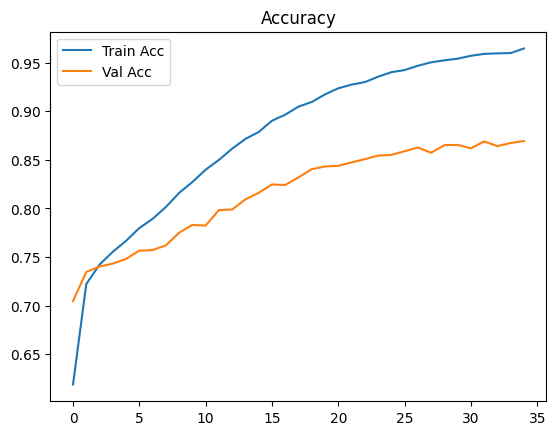

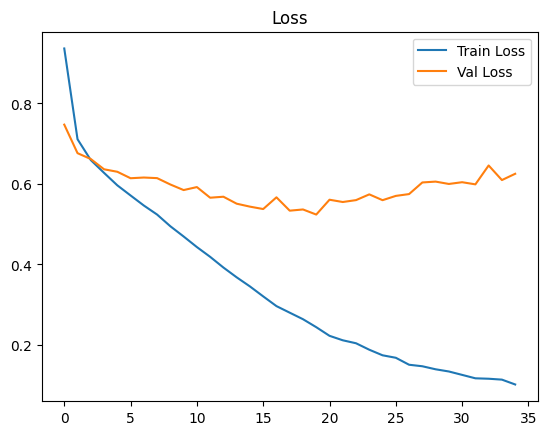

In [40]:
# 8. Plot learning curves
plt.plot(history_LSTM.history['accuracy'], label='Train Acc')
plt.plot(history_LSTM.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [41]:
# Making Predictio on Test Data
y_pred = model_LSTM.predict(X_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))

y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))

494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [42]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3922
           1       0.82      0.82      0.82      3947
           2       0.91      0.85      0.88      3942
           3       0.85      0.93      0.89      3971

    accuracy                           0.87     15782
   macro avg       0.87      0.87      0.87     15782
weighted avg       0.87      0.87      0.87     15782



Text(183.22222222222223, 0.5, 'Truth')

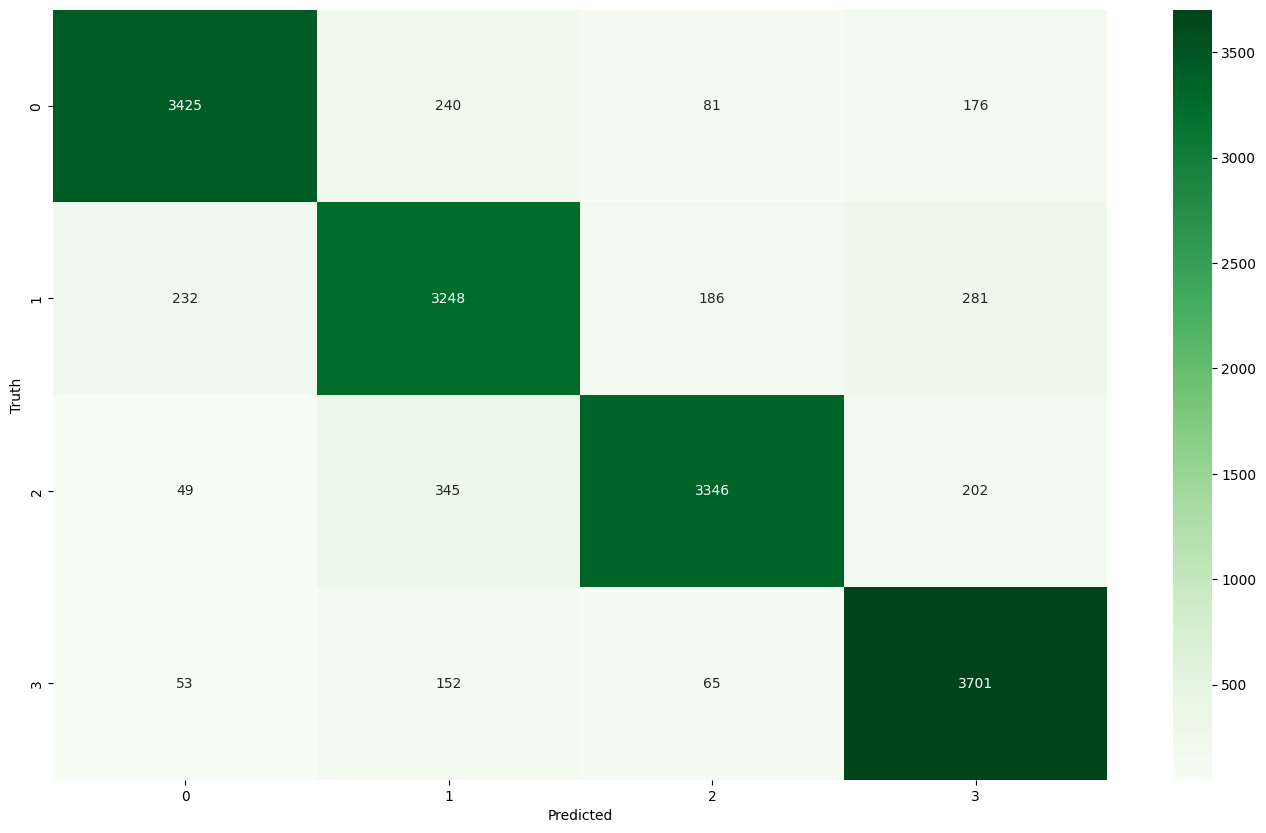

In [43]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length))
model_RNN.add(Bidirectional(SimpleRNN(32, return_sequences=True))),
model_RNN.add(Dropout(0.5)),
model_RNN.add(SimpleRNN(32)),
model_RNN.add(Dropout(0.5)),
model_RNN.add(Dense(64, activation='relu')),
model_RNN.add(Dense(4, activation='softmax'))
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
model_RNN.build(input_shape=(None, max_length))

In [46]:
model_RNN.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 10, 64)         │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,684 (295.64 KB)

 Trainable params: 75,684 (295.64 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_RNN=model_RNN.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5978 - loss: 0.9841 - val_accuracy: 0.7109 - val_loss: 0.7332
Epoch 2/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7088 - loss: 0.7467 - val_accuracy: 0.7247 - val_loss: 0.6948
Epoch 3/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7441 - loss: 0.6716 - val_accuracy: 0.7567 - val_loss: 0.6342
Epoch 4/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7725 - loss: 0.6070 - val_accuracy: 0.7628 - val_loss: 0.6269
Epoch 5/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7926 - loss: 0.5611 - val_accuracy: 0.7803 - val_loss: 0.5930
Epoch 6/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8078 - loss: 0.5274 - val_accuracy: 0.7814 - val_loss: 0.5971
Epoch 7/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8246 - loss: 0.4911 - val_accuracy: 0.7870 - val_loss: 0.5900
Epoch 8/35
576/576 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8306 - loss: 0.4628 - val_accuracy: 

In [48]:
# 7. Evaluate model
test_loss, test_accuracy = model_RNN.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8581 - loss: 0.5952
Test Accuracy: 0.8595


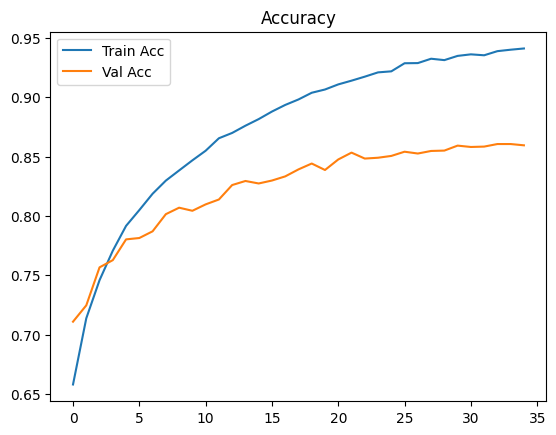

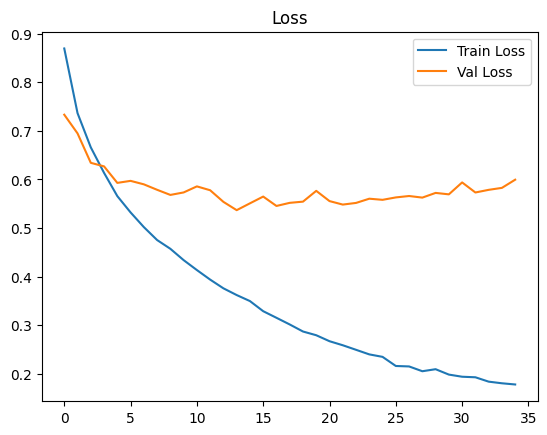

In [49]:
# 8. Plot learning curves
plt.plot(history_RNN.history['accuracy'], label='Train Acc')
plt.plot(history_RNN.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history_RNN.history['loss'], label='Train Loss')
plt.plot(history_RNN.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [50]:
# Making Predictio on Test Data
y_pred = model_RNN.predict(X_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))

y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))

494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [51]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3922
           1       0.80      0.81      0.80      3947
           2       0.87      0.86      0.87      3942
           3       0.86      0.92      0.89      3971

    accuracy                           0.86     15782
   macro avg       0.86      0.86      0.86     15782
weighted avg       0.86      0.86      0.86     15782



Text(183.22222222222223, 0.5, 'Truth')

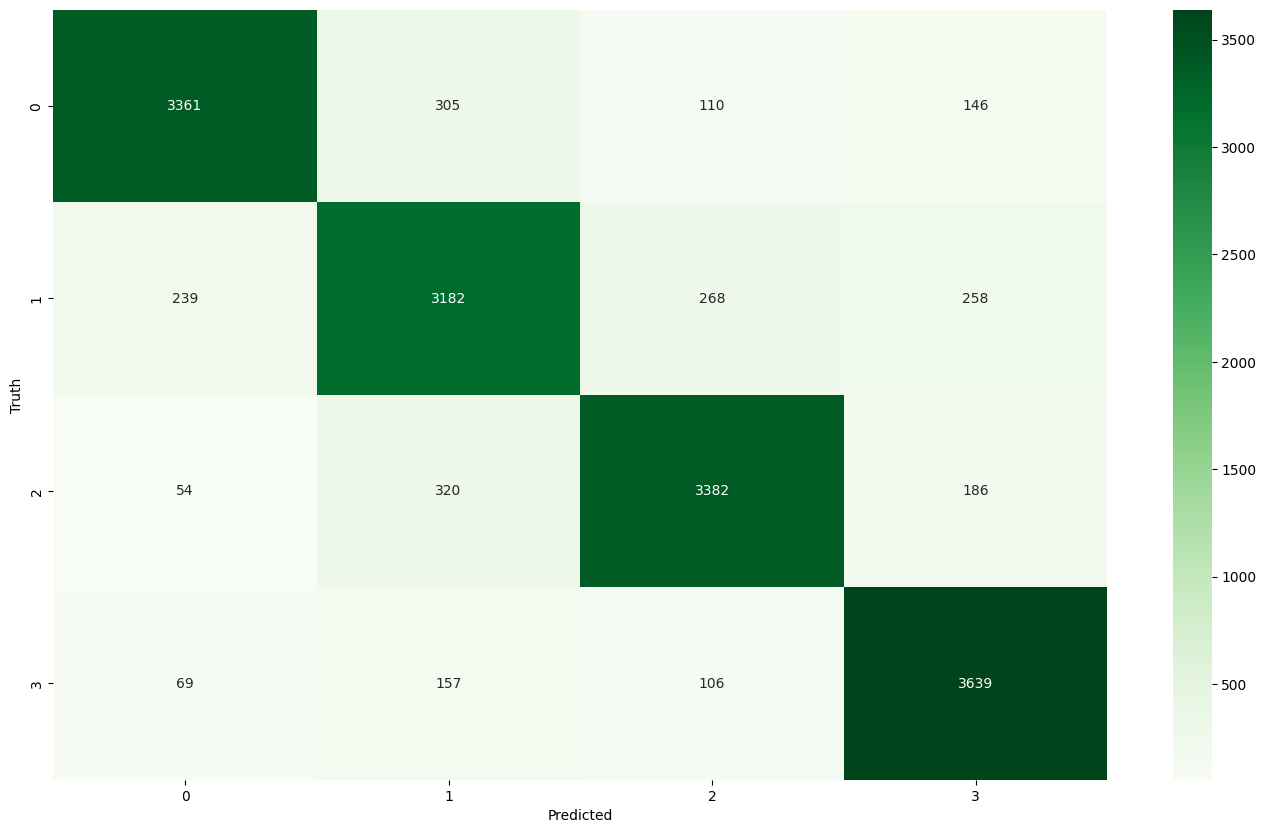

In [52]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
# Example input
sample_text = "i will kill me "
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_length, padding='post')

# Predict using LSTM model
lstm_pred = model_LSTM.predict(sample_pad)
lstm_label = label_encoder.inverse_transform([np.argmax(lstm_pred)])[0]
print("LSTM Model Prediction:", lstm_label)

# Predict using RNN model
rnn_pred = model_RNN.predict(sample_pad)
rnn_label = label_encoder.inverse_transform([np.argmax(rnn_pred)])[0]
print("RNN Model Prediction:", rnn_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LSTM Model Prediction: Moderate Risk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
RNN Model Prediction: High Risk
